# Load module and install

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
import regex as re
from transformers import AutoTokenizer, AutoModelForCausalLM, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report, mean_absolute_error, mean_squared_error
import torch
from torch.utils.data import DataLoader
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Section 1

In [3]:
def normalize_dataset(data):
    if not data:
        raise ValueError('The input data should list not empty')
    # ex: [10, 25, 15, 30]
    min_value = min(data) #30
    max_value = max(data)  #10

    if min_value == max_value: 
        raise ValueError('The input data is constant value') 

    # min-max scaling. if 25 -> (25-10) / (30-10) = 0.75
    normalized = [(point - min_value)/(max_value - min_value)  for point in data]

    return normalized 

# how to use ? below this example
dataset = [10, 25, 15, 30] 
normalize_dataset(dataset)

[0.0, 0.75, 0.25, 1.0]

In [4]:
df_healthcare = pd.read_csv('/kaggle/input/tech-chup/Dataset/healthcare.csv')
df_healthcare.describe()

,PatientID,Age,BMI,BloodPressure,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000
mean,384.500000,33.240885,31.992578,69.105469,0.348958
std,221.846794,11.760232,7.884160,19.355807,0.476951
min,1.000000,21.000000,0.000000,0.000000,0.000000
25%,192.750000,24.000000,27.300000,62.000000,0.000000
50%,384.500000,29.000000,32.000000,72.000000,0.000000
75%,576.250000,41.000000,36.600000,80.000000,1.000000
max,768.000000,81.000000,67.100000,122.000000,1.000000


In [5]:
# Mean of Age and BMI
mean_age = df_healthcare['Age'].mean()
mean_bmi = df_healthcare['BMI'].mean()

# Std of Age and BMI
std_age = df_healthcare['Age'].std()
std_bmi = df_healthcare['BMI'].std() 

print(f'Age -> mean:{mean_age} and std:{std_age}')
print(f'BMI -> mean:{mean_bmi} and std:{std_bmi}')

Age -> mean:33.240885416666664 and std:11.760231540678685
BMI -> mean:31.992578124999998 and std:7.884160320375446


In [6]:
# Filter the DataFrame to include only patients with a BloodPressure > 130
filter_BP = df_healthcare[df_healthcare['BloodPressure'] > 130]
filter_BP

,PatientID,Age,BMI,BloodPressure,Outcome


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


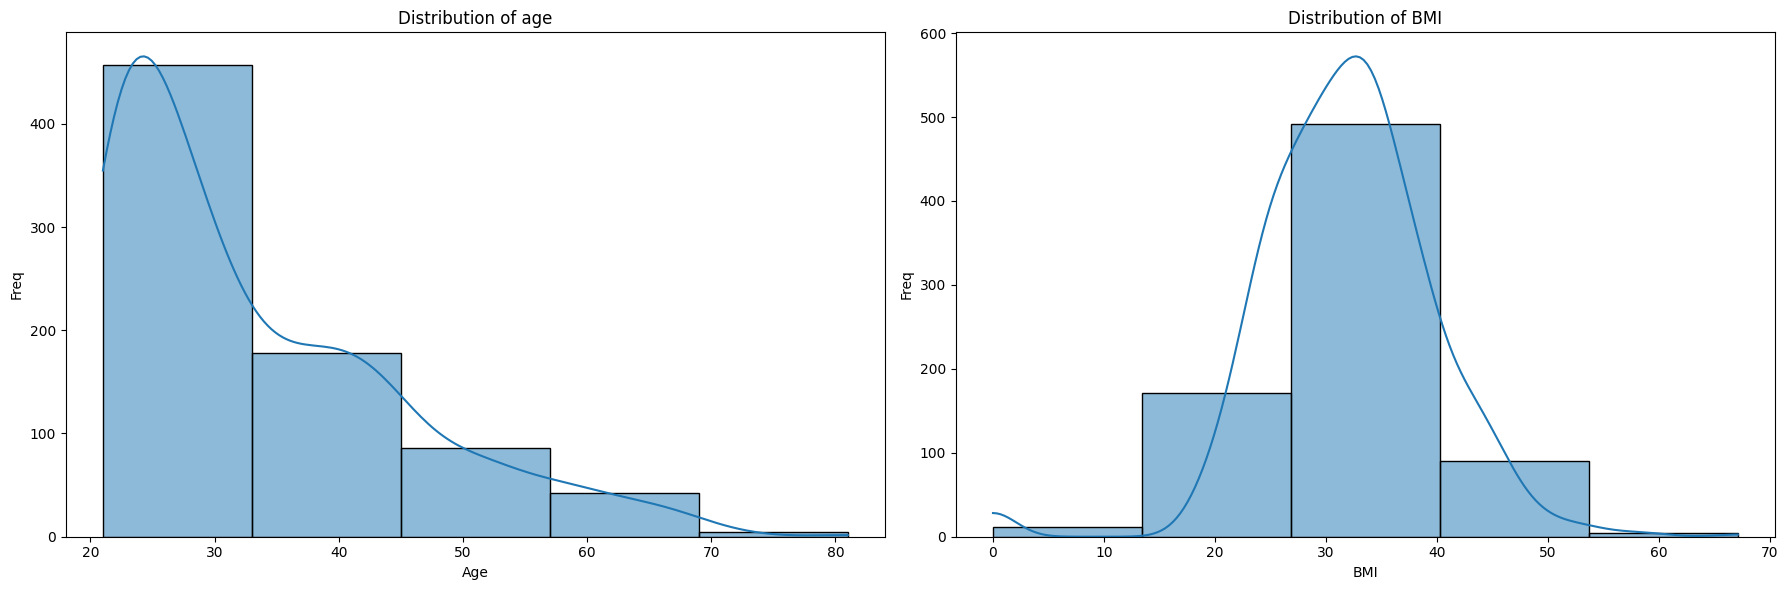

In [7]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_healthcare['Age'], kde=True, bins=5)
plt.title('Distribution of age')
plt.xlabel('Age')
plt.ylabel('Freq')

plt.subplot(1, 2, 2)
sns.histplot(df_healthcare['BMI'], kde=True, bins=5)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Freq')

plt.tight_layout()
plt.show()

Distribution of age:
1. There're so few individuals above 60y, suggesting that older age groups are underrepresented in this dataset.
2. with most individuals concentrated in the younger age groups, specifically in the 20–30 range

Distribution of BMI:
1. Most individuals have a BMI between 25 < x <= 40 that represents who're overweight obeseclassifications.

# Section 2

In [58]:
target = df_mtsamples['label'].unique().tolist()
target = {v: i for i, v in enumerate(target)} 
target

{' Allergy / Immunology': 0,
 ' Bariatrics': 1,
 ' Cardiovascular / Pulmonary': 2,
 ' Neurology': 3,
 ' Dentistry': 4,
 ' Urology': 5,
 ' General Medicine': 6,
 ' Surgery': 7,
 ' Speech - Language': 8,
 ' SOAP / Chart / Progress Notes': 9,
 ' Sleep Medicine': 10,
 ' Rheumatology': 11,
 ' Radiology': 12,
 ' Psychiatry / Psychology': 13,
 ' Podiatry': 14,
 ' Physical Medicine - Rehab': 15,
 ' Pediatrics - Neonatal': 16,
 ' Pain Management': 17,
 ' Orthopedic': 18,
 ' Ophthalmology': 19,
 ' Office Notes': 20,
 ' Obstetrics / Gynecology': 21,
 ' Neurosurgery': 22,
 ' Nephrology': 23,
 ' Letters': 24,
 ' Lab Medicine - Pathology': 25,
 ' IME-QME-Work Comp etc.': 26,
 ' Hospice - Palliative Care': 27,
 ' Hematology - Oncology': 28,
 ' Gastroenterology': 29,
 ' ENT - Otolaryngology': 30,
 ' Endocrinology': 31,
 ' Emergency Room Reports': 32,
 ' Discharge Summary': 33,
 ' Diets and Nutritions': 34,
 ' Dermatology': 35,
 ' Cosmetic / Plastic Surgery': 36,
 ' Consult - History and Phy.': 37,
 ' 

In [57]:
df_mtsamples = pd.read_csv('/kaggle/input/tech-chup/Dataset/mtsamples.csv')
df_mtsamples.head()

,text,label
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary


In [59]:
df_mtsamples['target'] = df_mtsamples['label'].apply(lambda x: target[x])
df_mtsamples

,text,label,target
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,0
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics,1
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics,1
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary,2
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,2
...,...,...,...
4994,"HISTORY:, I had the pleasure of meeting and e...",Allergy / Immunology,0
4995,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,0
4996,"SUBJECTIVE: , This is a 42-year-old white fema...",Allergy / Immunology,0
4997,"CHIEF COMPLAINT: , This 5-year-old male presen...",Allergy / Immunology,0


In [60]:
df_mtsamples[df_mtsamples['text'].isna()]

,text,label,target
97,NaN,Urology,5
116,NaN,Urology,5
205,NaN,Surgery,7
263,NaN,Surgery,7
459,NaN,Surgery,7
622,NaN,Surgery,7
628,NaN,Surgery,7
680,NaN,Surgery,7
729,NaN,Surgery,7
871,NaN,Surgery,7


In [61]:
df_mtsamples_clean = df_mtsamples.dropna()
df_mtsamples_clean[df_mtsamples_clean['text'].isna()]

,text,label,target


In [62]:
def preprocessing(text):
    # lowercase
    text = text.lower()

    # tokenize
    words = word_tokenize(text)
    
    # remove stopword
    mystopword = set(stopwords.words('english'))
    words = [token for token in words if token not in mystopword]

    text = ' '.join(words)
    cleaned_text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    return cleaned_text

In [63]:
df_mtsamples_clean['txt_result'] = df_mtsamples_clean['text'].apply(lambda x: preprocessing(x))
df_mtsamples_clean

/tmp/ipykernel_30/3119951299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mtsamples_clean['txt_result'] = df_mtsamples_clean['text'].apply(lambda x: preprocessing(x))


,text,label,target,txt_result
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,0,subjective 23yearold white female presents c...
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics,1,past medical history difficulty climbing sta...
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",Bariatrics,1,history present illness seen abc today plea...
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",Cardiovascular / Pulmonary,2,2d mmode 1 left atrial enlargement left atri...
4,1. The left ventricular cavity size and wall ...,Cardiovascular / Pulmonary,2,1 left ventricular cavity size wall thickness ...
...,...,...,...,...
4994,"HISTORY:, I had the pleasure of meeting and e...",Allergy / Immunology,0,history pleasure meeting evaluating patient ...
4995,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,0,admitting diagnosis kawasaki disease discha...
4996,"SUBJECTIVE: , This is a 42-year-old white fema...",Allergy / Immunology,0,subjective 42yearold white female comes toda...
4997,"CHIEF COMPLAINT: , This 5-year-old male presen...",Allergy / Immunology,0,chief complaint 5yearold male presents child...


## pretrained-cls

Based on contextual data, preprocessing only needs lowercase, tokenize and stopword removal

In [64]:
dataset = df_mtsamples_clean[['txt_result', 'target']] 
sum_train = round(len(dataset) * 0.8)
sum_valtest = round(len(dataset) * 0.1)

training = dataset[:sum_train]
validation = dataset[sum_train-sum_valtest:sum_train]
testing = dataset[sum_train+sum_valtest:]

In [65]:
len(training) + len(validation) + len(testing), '->',  len(dataset)

(4966, '->', 4966)

In [66]:
training = training.rename(columns={'target': 'labels'})
testing = testing.rename(columns={'target': 'labels'})
validation = validation.rename(columns={'target': 'labels'})

In [67]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [68]:
def tokenize(batch):
    return tokenizer(batch['txt_result'], padding=True, truncation=True, max_length=128)

In [69]:
train_dataset = Dataset.from_pandas(training)
test_dataset = Dataset.from_pandas(testing)
val_dataset = Dataset.from_pandas(validation)

In [70]:
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3973 [00:00<?, ? examples/s]

Map:   0%|          | 0/496 [00:00<?, ? examples/s]

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

In [71]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [73]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # Get the predicted class from logits
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')  # Use 'macro' for multiclass
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.losses.append(logs['loss'])

In [74]:
loss_history = LossHistoryCallback()

Model pre-trained used DistilBert for Encoder-Based model

In [75]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df_mtsamples_clean['target'].unique()))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
10,3.721500,3.720660,0.000000,0.000000,0.000000,0.000000
20,3.706100,3.719779,0.000000,0.000000,0.000000,0.000000
30,3.681900,3.718865,0.000000,0.000000,0.000000,0.000000
40,3.648600,3.717656,0.000000,0.000000,0.000000,0.000000
50,3.597100,3.709578,0.000000,0.000000,0.000000,0.000000
60,3.500600,3.668566,0.000000,0.000000,0.000000,0.000000
70,3.355700,3.612849,0.000000,0.000000,0.000000,0.000000
80,3.255600,3.614759,0.000000,0.000000,0.000000,0.000000
90,3.167900,3.642668,0.000000,0.000000,0.000000,0.000000
100,3.048800,3.665184,0.000000,0.000000,0.000000,0.000000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarn

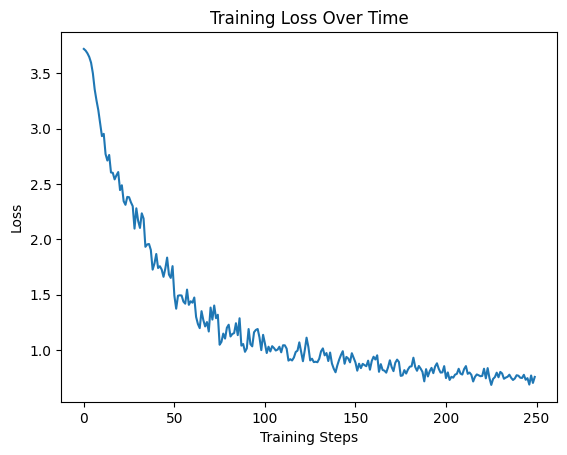

In [76]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    save_strategy='no',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs',
    logging_steps=10,           
    evaluation_strategy="steps",
    save_steps=10,               
    eval_steps=10               
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,    
    callbacks=[loss_history]           
)

# Train the model
trainer.train()

# Plotting the loss history
plt.plot(loss_history.losses)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Test Accuracy: 0.0020161290322580645
Test F1 Score (Macro): 0.006666666666666667
Test Precision (Macro): 0.016666666666666666
Test Recall (Macro): 0.004166666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.12      0.20         8
           2       0.00      0.00      0.00       365
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         0
          19       0.00      0.00      0.00        

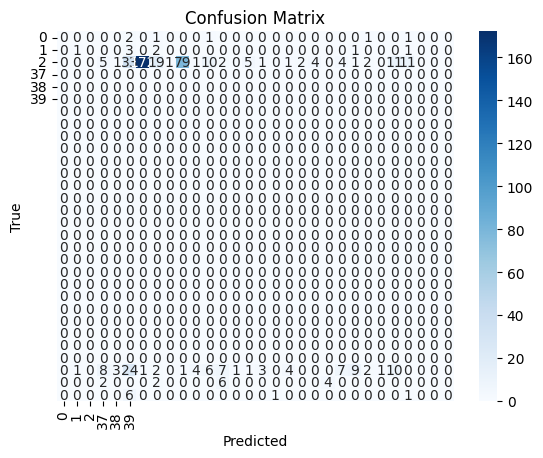

In [105]:
predictions, labels, metrics = trainer.predict(test_dataset)

# Convert logits to class predictions
predicted_labels = np.argmax(predictions, axis=1)

# Print out metrics from the Trainer's predict method
print(f"Test Accuracy: {metrics['test_accuracy']}")
print(f"Test F1 Score (Macro): {metrics['test_f1']}")
print(f"Test Precision (Macro): {metrics['test_precision']}")
print(f"Test Recall (Macro): {metrics['test_recall']}")

# Generate and print a classification report
report = classification_report(test_dataset['labels'].tolist(), predicted_labels)  # Adjust class names as needed
print("Classification Report:\n", report)

# Confusion Matrix
cm = confusion_matrix(labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset['labels'].unique().tolist(), yticklabels=test_dataset['labels'].unique().tolist())  # Adjust class names
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [106]:
model.save_pretrained('/kaggle/working/final-model-distilbert')
tokenizer.save_pretrained('/kaggle/working/final-model-distilbert')

('/kaggle/working/final-model-distilbert/tokenizer_config.json',
 '/kaggle/working/final-model-distilbert/special_tokens_map.json',
 '/kaggle/working/final-model-distilbert/vocab.txt',
 '/kaggle/working/final-model-distilbert/added_tokens.json')

## pretrained-generated

In [171]:
generated = df_mtsamples_clean[['txt_result', 'label']]
generated = generated.rename(columns={'txt_result': 'response', 'label': 'instruct'})

In [172]:
train_df = generated.sample(frac=0.8, random_state=42)  # 80% untuk pelatihan
test_df = generated.drop(train_df.index)  # 20% untuk pengujian

# Selanjutnya, dari data pelatihan, kita ambil subset validasi 20%
val_df = train_df.sample(frac=0.2, random_state=42)  # 20% dari pelatihan untuk validasi

In [173]:
model_name = "gpt2" 
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token 

# Tokenize the dataset
def tokenize_function(examples):
    tokens = tokenizer(examples['instruct'], examples['response'], truncation=True, max_length=512, padding="max_length")
    tokens["labels"] = tokens["input_ids"].copy()  
    return tokens

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3973 [00:00<?, ? examples/s]

Map:   0%|          | 0/993 [00:00<?, ? examples/s]

Map:   0%|          | 0/795 [00:00<?, ? examples/s]

In [160]:
val_dataset.shape

(795, 5)

In [174]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/fine_tuned_model",
    evaluation_strategy="epoch",
    save_strategy='no',
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [175]:
trainer.train()
model.save_pretrained("/kaggle/working/fine_tuned_instruct_model")
tokenizer.save_pretrained("/kaggle/working/fine_tuned_instruct_model")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,3.049900,2.450221
2,2.473600,2.251028
3,2.338000,2.192214


('/kaggle/working/fine_tuned_instruct_model/tokenizer_config.json',
 '/kaggle/working/fine_tuned_instruct_model/special_tokens_map.json',
 '/kaggle/working/fine_tuned_instruct_model/vocab.json',
 '/kaggle/working/fine_tuned_instruct_model/merges.txt',
 '/kaggle/working/fine_tuned_instruct_model/added_tokens.json',
 '/kaggle/working/fine_tuned_instruct_model/tokenizer.json')

In [176]:
from transformers import pipeline

instruction_pipeline = pipeline("text-generation", model="/kaggle/working/fine_tuned_instruct_model", tokenizer=tokenizer)

prompt = "Generate a short medical report for a patient with diabetes."
response = instruction_pipeline(prompt, max_length=150, do_sample=True, temperature=0.7)
print(response[0]['generated_text'])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generate a short medical report for a patient with diabetes.  patient started patient s diabetes treatment  patient reports diabetes  status post ciprofloxacin  patient reports regular activities daily living lives fulltime  works fulltime  family members  past medical history  1 diabetes2  hypertension3  hypertension four years  medications   aspirin  metoprolol  metoprolol  zoloft  allergies   known drug allergies  review systems   patient denies fever chills  chills sweats  chills  chills  chills  weight loss  weight gain  shortness breath  respiratory  shortness breath  shortness breath  weight loss  nausea  vomiting  diarrhea  hematemesis fever 


# section 3

## EDA

In [221]:
df_waiting_est = pd.read_csv('/kaggle/input/tech-chup/Dataset/waiting_time_estimation_data.csv')
df_waiting_est

,arrival_time,start_time,finish_time,wait_time,queue_length
0,30-03-2023 0.10,30-03-2023 0.10,2023-03-30 00:22:44.800000000,12.68,28
1,30-03-2023 0.10,30-03-2023 0.16,2023-03-30 00:25:53.200000000,9.82,28
2,30-03-2023 0.10,30-03-2023 0.16,2023-03-30 00:25:48.400000000,9.74,28
3,30-03-2023 0.10,30-03-2023 0.14,2023-03-30 00:27:23.200000000,13.32,28
4,30-03-2023 0.10,30-03-2023 0.15,2023-03-30 00:31:21.400000000,16.29,28
...,...,...,...,...,...
555,30-03-2023 22.00,30-03-2023 22.02,2023-03-30 22:16:59.800000000,14.83,12
556,30-03-2023 22.00,30-03-2023 22.10,2023-03-30 22:13:56.200000000,3.77,12
557,30-03-2023 22.00,30-03-2023 22.00,2023-03-30 22:05:35.799999999,5.43,12
558,30-03-2023 23.54,30-03-2023 23.54,2023-03-31 00:00:42.400000000,5.74,2


In [222]:
 df_waiting_est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arrival_time  560 non-null    object 
 1   start_time    560 non-null    object 
 2   finish_time   560 non-null    object 
 3   wait_time     560 non-null    float64
 4   queue_length  560 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 22.0+ KB


## preprocessing

In [223]:
df_waiting_est['arrival_time'] = pd.to_datetime(df_waiting_est['arrival_time'], format='%d-%m-%Y %H.%M')
df_waiting_est['start_time'] = pd.to_datetime(df_waiting_est['start_time'], format='%d-%m-%Y %H.%M')
df_waiting_est['finish_time'] = pd.to_datetime(df_waiting_est['finish_time'], errors='coerce')
df_waiting_est

,arrival_time,start_time,finish_time,wait_time,queue_length
0,2023-03-30 00:10:00,2023-03-30 00:10:00,2023-03-30 00:22:44.800000000,12.68,28
1,2023-03-30 00:10:00,2023-03-30 00:16:00,2023-03-30 00:25:53.200000000,9.82,28
2,2023-03-30 00:10:00,2023-03-30 00:16:00,2023-03-30 00:25:48.400000000,9.74,28
3,2023-03-30 00:10:00,2023-03-30 00:14:00,2023-03-30 00:27:23.200000000,13.32,28
4,2023-03-30 00:10:00,2023-03-30 00:15:00,2023-03-30 00:31:21.400000000,16.29,28
...,...,...,...,...,...
555,2023-03-30 22:00:00,2023-03-30 22:02:00,2023-03-30 22:16:59.800000000,14.83,12
556,2023-03-30 22:00:00,2023-03-30 22:10:00,2023-03-30 22:13:56.200000000,3.77,12
557,2023-03-30 22:00:00,2023-03-30 22:00:00,2023-03-30 22:05:35.799999999,5.43,12
558,2023-03-30 23:54:00,2023-03-30 23:54:00,2023-03-31 00:00:42.400000000,5.74,2


In [224]:
missing_values = df_waiting_est.isnull().sum()
df_waiting_est.describe(include='all'), missing_values

(              arrival_time                     start_time  \
 count                  560                            560   
 mean   2023-03-30 11:14:36  2023-03-30 11:19:08.464285696   
 min    2023-03-30 00:10:00            2023-03-30 00:10:00   
 25%    2023-03-30 05:34:00            2023-03-30 05:37:00   
 50%    2023-03-30 10:31:00            2023-03-30 10:38:00   
 75%    2023-03-30 16:45:00            2023-03-30 16:54:15   
 max    2023-03-30 23:54:00            2023-03-30 23:58:00   
 std                    NaN                            NaN   
 
                          finish_time   wait_time  queue_length  
 count                            560  560.000000    560.000000  
 mean   2023-03-30 11:29:43.021071360   10.107911     32.132143  
 min       2023-03-30 00:19:27.400000   -2.930000      2.000000  
 25%    2023-03-30 05:46:51.750000128    6.527500     24.750000  
 50%              2023-03-30 10:49:47   10.120000     30.000000  
 75%       2023-03-30 17:08:23.300000   13.3

In [225]:
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

In [226]:
df_waiting_est['arrival_hour'] = df_waiting_est['arrival_time'].dt.hour
df_waiting_est['arrival_hour'] = df_waiting_est['arrival_time'].dt.hour
df_waiting_est['arrival_dayofweek'] = df_waiting_est['arrival_time'].dt.dayofweek  

df_waiting_est['time_of_day'] = df_waiting_est['arrival_hour'].apply(lambda x: time_of_day(x))

df_waiting_est['cumulative_queue'] = df_waiting_est['queue_length'].cumsum()

df_waiting_est['avg_wait_by_day_time'] = df_waiting_est.groupby(['arrival_dayofweek', 'time_of_day'])['wait_time'].transform('mean')
df_waiting_est['avg_queue_by_day_time'] = df_waiting_est.groupby(['arrival_dayofweek', 'time_of_day'])['queue_length'].transform('mean')

In [227]:
df_waiting_est

,arrival_time,start_time,finish_time,wait_time,queue_length,arrival_hour,arrival_dayofweek,time_of_day,cumulative_queue,avg_wait_by_day_time,avg_queue_by_day_time
0,2023-03-30 00:10:00,2023-03-30 00:10:00,2023-03-30 00:22:44.800000000,12.68,28,0,3,night,28,10.044045,33.258427
1,2023-03-30 00:10:00,2023-03-30 00:16:00,2023-03-30 00:25:53.200000000,9.82,28,0,3,night,56,10.044045,33.258427
2,2023-03-30 00:10:00,2023-03-30 00:16:00,2023-03-30 00:25:48.400000000,9.74,28,0,3,night,84,10.044045,33.258427
3,2023-03-30 00:10:00,2023-03-30 00:14:00,2023-03-30 00:27:23.200000000,13.32,28,0,3,night,112,10.044045,33.258427
4,2023-03-30 00:10:00,2023-03-30 00:15:00,2023-03-30 00:31:21.400000000,16.29,28,0,3,night,140,10.044045,33.258427
...,...,...,...,...,...,...,...,...,...,...,...
555,2023-03-30 22:00:00,2023-03-30 22:02:00,2023-03-30 22:16:59.800000000,14.83,12,22,3,night,17966,10.044045,33.258427
556,2023-03-30 22:00:00,2023-03-30 22:10:00,2023-03-30 22:13:56.200000000,3.77,12,22,3,night,17978,10.044045,33.258427
557,2023-03-30 22:00:00,2023-03-30 22:00:00,2023-03-30 22:05:35.799999999,5.43,12,22,3,night,17990,10.044045,33.258427
558,2023-03-30 23:54:00,2023-03-30 23:54:00,2023-03-31 00:00:42.400000000,5.74,2,23,3,night,17992,10.044045,33.258427


In [257]:
unique_tod = df_waiting_est['time_of_day'].unique().tolist()
tod = {v:i for i, v in enumerate(unique_tod)}

df_waiting_est['tod'] =df_waiting_est['time_of_day'].apply(lambda x: tod[x])

In [258]:
feature = ['wait_time', 'queue_length', 'arrival_hour',	'tod', 'cumulative_queue', 
           'arrival_dayofweek', 'avg_wait_by_day_time', 'avg_queue_by_day_time'
]

In [259]:
scaler = StandardScaler()
df_waiting_est[feature] = scaler.fit_transform(df_waiting_est[feature])
data_fix = df_waiting_est[feature]
data_fix

,wait_time,queue_length,arrival_hour,tod,cumulative_queue,arrival_dayofweek,avg_wait_by_day_time,avg_queue_by_day_time
0,0.511562,-0.333051,-1.586744,-1.15854,-1.776470,0.0,-0.143048,0.213199
1,-0.057262,-0.333051,-1.586744,-1.15854,-1.771207,0.0,-0.143048,0.213199
2,-0.073174,-0.333051,-1.586744,-1.15854,-1.765943,0.0,-0.143048,0.213199
3,0.638852,-0.333051,-1.586744,-1.15854,-1.760680,0.0,-0.143048,0.213199
4,1.229554,-0.333051,-1.586744,-1.15854,-1.755417,0.0,-0.143048,0.213199
...,...,...,...,...,...,...,...,...
555,0.939175,-1.622650,1.674088,-1.15854,1.595353,0.0,-0.143048,0.213199
556,-1.260546,-1.622650,1.674088,-1.15854,1.597609,0.0,-0.143048,0.213199
557,-0.930389,-1.622650,1.674088,-1.15854,1.599864,0.0,-0.143048,0.213199
558,-0.868733,-2.428649,1.822308,-1.15854,1.600240,0.0,-0.143048,0.213199


## feature selection

In [261]:
y = data_fix['wait_time']
X = data_fix.drop(columns=['wait_time'])

In [263]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)  
rfe.fit(X, y)

selected_ft = X.columns[rfe.support_]
selected_ft

Index(['queue_length', 'tod', 'cumulative_queue', 'avg_wait_by_day_time',
       'avg_queue_by_day_time'],
      dtype='object')

In [276]:
X = data_fix[list(selected_ft)]
X

,queue_length,tod,cumulative_queue,avg_wait_by_day_time,avg_queue_by_day_time
0,-0.333051,-1.15854,-1.776470,-0.143048,0.213199
1,-0.333051,-1.15854,-1.771207,-0.143048,0.213199
2,-0.333051,-1.15854,-1.765943,-0.143048,0.213199
3,-0.333051,-1.15854,-1.760680,-0.143048,0.213199
4,-0.333051,-1.15854,-1.755417,-0.143048,0.213199
...,...,...,...,...,...
555,-1.622650,-1.15854,1.595353,-0.143048,0.213199
556,-1.622650,-1.15854,1.597609,-0.143048,0.213199
557,-1.622650,-1.15854,1.599864,-0.143048,0.213199
558,-2.428649,-1.15854,1.600240,-0.143048,0.213199


## Modeling

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [278]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, max_samples=0.5, n_jobs=-1)  # `max_samples` is subsampling
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_samples=0.5, n_jobs=-1)

In [279]:
y_pred = model.predict(X_test)
y_pred

array([ 0.10621414, -0.21008601,  0.11102583, -0.17025509,  0.29119703,
       -0.14403155,  0.08429077, -0.6448025 , -0.89595203,  0.06711881,
        0.23153652,  0.06636974,  0.01399366, -0.21650045,  0.15399546,
       -0.01497161,  0.03062253,  0.08816049, -0.43998506,  0.01605098,
       -0.44916856, -0.28619781,  0.4194953 , -0.19820328, -0.50879677,
        0.29068992,  0.81322887,  0.41209397, -0.26773988,  0.18464569,
       -0.08698833, -0.10942134, -0.43756958,  0.4670919 , -0.1546844 ,
        0.2919665 ,  0.54884887,  0.29869448, -0.53432416,  0.25212053,
       -0.35172537,  0.68054845,  0.04298128,  0.42534274,  0.15233687,
        0.50479466,  0.04881074, -0.2884443 ,  0.22360535, -1.28821641,
        0.17382335,  0.46119595, -0.19515228, -0.05551275,  0.12493231,
       -0.26120733,  0.00608271, -0.52149577,  0.33225107,  0.18803557,
        0.31169104, -0.1418378 ,  0.48313847,  0.46403915,  0.30960754,
       -0.05513241,  0.17851656, -0.45047753,  0.8615627 , -0.43

In [280]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Mae: ', mae)
print('rmse: ', rmse)

Mae:  0.837617883268001
rmse:  1.0792871099843309


In [282]:
model_filename = "/kaggle/working/section3_rf_model.joblib"
joblib.dump(model, model_filename)

['/kaggle/working/section3_rf_model.joblib']